In [3]:
import requests
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
import pandas as pd
import csv
import time
import operator
import re

In [4]:
#main sourcde url 
m_url ="https://www.nytimes.com/search?dropmab=false&endDate=20200229&query=%22construction%22%20accident&sort=best&startDate=20000101"

In [5]:
session = requests.Session()
req=session.get(m_url) #default is s_url
soup = BeautifulSoup(req.text, 'html.parser')

#stream-panel > div.css-13mho3u > ol > li:nth-child(2) > div > div.css-1l4spti > a
#stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a


In [6]:

chrome_options = webdriver.ChromeOptions
#chrome_options.add_argument("--incognito")
driver = webdriver.Chrome(executable_path='/Users/macbookpro/Desktop/Project/Construction_analysis/chromedriver')

link = []
driver.get(m_url)
time.sleep(3)
for i in range(100) :
    a = driver.page_source
    b = BeautifulSoup(a, 'html.parser')
    #stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a
    #stream-panel > div.css-13mho3u > ol > li > div > div.css-1l4spti > a
    #site-content > div > div:nth-child(2) > div.css-46b038 > ol > li:nth-child(1) > div > div > div > a
    c = b.select('#site-content > div >div>div> ol >li> div > div > div > a')
    
    for j in range(len(c)) :
        if c[j].attrs['href'] not in link :
            link.append(c[j].attrs['href'])
        else :
            pass
    
    driver.find_element_by_xpath('//*[@id="site-content"]/div/div[2]/div[2]/div/button').click()
    time.sleep(3)

#link

In [7]:
link_source = link 

a_link = link

print(len(a_link))


1000


In [8]:
diff_link = []

#delete unsupported news 
for i in range (len(a_link)) :
    print(a_link[i])
    if a_link[i][1] != '2':
        
        diff_link.append(a_link[i])
            
    else : 
        continue

for j in range(len(diff_link)):
    if diff_link[j] in a_link:
        a_link.remove(diff_link[j])
        



/2020/02/17/nyregion/construction-deaths-latinos-nyc.html?searchResultPosition=1
/2020/01/30/nyregion/nyc-scaffolding-building-facades.html?searchResultPosition=2
/2019/11/22/nyregion/nyc-dob-surprise-inspectors.html?searchResultPosition=3
/2019/11/29/us/hard-rock-hotel-worker-immigration.html?searchResultPosition=4
/2007/09/13/nyregion/13mbrfs-DEATHS.html?searchResultPosition=5
/2015/06/03/nyregion/fatal-construction-accidents-are-rising-in-new-york.html?searchResultPosition=6
/2006/11/22/nyregion/fatal-construction-accidents-in-the-city-rise-sharply-over-12.html?searchResultPosition=7
/2006/11/22/nyregion/22construct.html?searchResultPosition=8
/2007/05/05/nyregion/05cave.html?searchResultPosition=9
https://cityroom.blogs.nytimes.com/2008/04/29/more-construction-accidents-2-workers-critically-injured/?searchResultPosition=10
/2002/08/27/nyregion/city-allows-work-to-resume-at-construction-accident-site.html?searchResultPosition=11
https://cityroom.blogs.nytimes.com/2007/08/23/new-scaf

In [9]:
## This is main source for analyzing article

class ArticleInfo():
    
    def __init__(self, s_url) :
        
        session = requests.Session()
        req=session.get(s_url)
        self.soup = BeautifulSoup(req.text, 'html.parser')
    
    
    def article_body(self) :
        body = self.soup.find('div', {'class' : 'StoryBodyCompanionColumn'})
        finalContent =''
    
        if body is not None :
            for itcontents in self.soup.findAll('p'):
                if itcontents == None :
                    continue
                content = itcontents.getText()
                content = re.sub(r"\n+", "", content)
                finalContent +=content
        else :
            return False
        
        return finalContent

##reference: https://github.com/subhendusethi/nytimes-article-crawler/blob/master/crawler/nytimescrawler.py    

    def article_title(self):
        titles = self.soup.select('title',{"data-rh":"true"})
        for title in titles:
            title = title.getText()
            break
        return title

    def article_date(self) :
  
        date = self.soup.find('li',{'class':'date'})
        if date != None :
            date = date.getText()
            
        else :
            date = self.soup.find('meta',{'name':'pdate'})
            if date !=None :
                date = date.get('content')
                if date !=None :
                    date = str(date)
                else:
                    none= "none"
                    datelist.append(none)
                
        return date

 

In [10]:
titles =[]
bodies =[]
datelist=[]

for s_url in a_link :
    s_url = 'https://www.nytimes.com'+s_url
    ob = ArticleInfo(s_url)
    
    body =ob.article_body()
    bodies.append(body)
    
    date = ob.article_date()
    datelist.append(date)
    
    title = ob.article_title()
    titles.append(title)

### Start Tokenize words with nltk

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.probability import ConditionalFreqDist
from gensim.models import Word2Vec
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:

#1. make lower case, regulazation
l_bodies=[]
for body in bodies :
    
    body = str(body).lower()
    l_bodies.append(body)

    
#2. removing stop words, tokenize
stop_words = set(stopwords.words('english'))

token_sentence = []
for words in l_bodies:
    word_tokens= word_tokenize(words)
    filter_sentence = [fw for fw in word_tokens if not fw in stop_words]
    #filter_sentence = [fs for fs in word_tokens if not fs in remove_list]
    
    for n in range(len(filter_sentence)) :
        if filter_sentence[n] == 'collapsed' :
            filter_sentence[n]  = 'collapse'
        elif filter_sentence[n] == 'buildings':
            filter_sentence[n] = 'building'
       
    ## fall + fell => fall (less frequency of fall just go with fell) , collapsed +collapse => collapse
    #filter_sentence = nltk.pos_tag(filter_sentence)
    token_sentence.append(filter_sentence)
    
#token_sentence
#print(l_bodies)



In [19]:
#check how many words I use 

len(token_sentence)
total_word_count = 0
for i in range(len(token_sentence)) :
    
    total_word_count += len(token_sentence[i])
print(total_word_count)

453283


In [824]:
#frequency of five keywords

cnt_fire =0 
cnt_fall =0
cnt_collapse =0 
cnt_people = 0
cnt_building = 0
for token in token_sentence :
    if 'fire' in token :
        cnt_fire +=1
    if 'collapse' in token :
        cnt_collapse +=1
    if 'fell' in token :
        cnt_fall +=1
    if 'building' in token :
        cnt_building +=1
    if 'people' in token :
        cnt_people +=1
        
freq_dict = {}
freq_dict['fire'] = cnt_fire
freq_dict['fell'] = cnt_fall
freq_dict['collapse'] = cnt_collapse
freq_dict['building'] = cnt_building
freq_dict['people'] = cnt_people
print(cnt_fire, cnt_fall, cnt_collapse)
print(len(token_sentence))


192 233 284
861


{'fire': 192, 'fell': 233, 'collapse': 284, 'building': 514, 'people': 492}


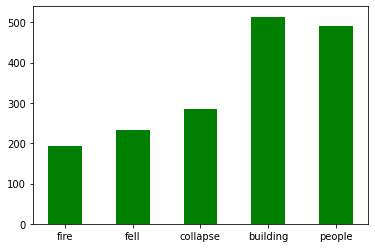

In [825]:
#frequency histogram of five keywords

import matplotlib.pyplot as plt
print(freq_dict)
plt.bar(list(freq_dict.keys()),freq_dict.values(),width = 0.5, color ='g')
plt.savefig('frequency_keyword.png')

In [696]:
#start word2vec

model = Word2Vec(token_sentence, size = 400, window=5, min_count=200, workers=3, sg=0, iter=5)

In [800]:
#check similarty between 5 keywords (total 10)
#fire - collapse, fire - fell, fire - people, fire - building
#collapse - fell, collapse - people , collapse - building
#fell - people , fell - building
#building - people 
sb1 = model.similarity('building','collapse')
sb2 = model.similarity('building','fire')
sb3 = model.similarity('building','people')
sb4 = model.similarity('building','fell')
sb5 = model.similarity('fire','collapse')
sb6 = model.similarity('fire','fell')
sb7 = model.similarity('fire','people')
sb8 = model.similarity('collapse','fell')
sb9 = model.similarity('collapse','people')
sb10 = model.similarity('people','fell')

print('building and collapse', model.similarity('building','collapse'))  ## similarity between words
print('building and fire', model.similarity('building','fire')) 
print('building and people', model.similarity('building','people')) 
print('building and fell', model.similarity('building','fell'))
print('fire and collapse', model.similarity('fire','collapse'))
print('fire and fell', model.similarity('fire','fell'))
print('fire and people', model.similarity('fire','people'))
print('collapse and fell', model.similarity('collapse','fell'))
print('collpase and people', model.similarity('collapse','people'))
print('people and fell', model.similarity('people','fell'))

sim_between = [('building and collapse' , sb1),('building and fire',sb2), ('building and people ',sb3), ('building and fall', sb4),
              ('fire and collapse', sb5), ('fire and fall', sb6), ('fire and people', sb7), ('collapse and fall', sb8), ('collapse and people', sb9),
              ('people and fall', sb10)]
df_sim_between = pd.DataFrame(sim_between, columns=['Words', 'Similarity'])
df_sim_between.to_csv('sim_between.csv')

building and collapse 0.5535143
building and fire 0.5253745
building and people -0.1435263
building and fell 0.44253662
fire and collapse 0.69090945
fire and fell 0.7277216
fire and people 0.33135825
collapse and fell 0.95054793
collpase and people 0.5097592
people and fell 0.4861988


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method wi

In [698]:
model.similarity('building','fire') 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5253745

In [798]:
# top 100 similiar word

sim_list_fire_100 = model.similar_by_vector('fire', topn=100, restrict_vocab=None)
sim_list_fall_100 = model.similar_by_vector('fell', topn=100, restrict_vocab=None)
sim_list_collapse_100 = model.similar_by_vector('collapse', topn=100, restrict_vocab=None)
sim_list_building_100 = model.similar_by_vector('building', topn=100, restrict_vocab=None)
sim_list_people_100 = model.similar_by_vector('people', topn=100, restrict_vocab= None)
print(sim_list_fire_100)
pd_fire_100 = pd.DataFrame(sim_list_fire_100,columns=['Word', 'Similarity'])
pd_fire_100.to_csv('Similar_words_100/fire_100.csv')
                   
pd_fall_100 = pd.DataFrame(sim_list_fall_100,columns=['Word','Similarity'])
pd_fall_100.to_csv('Similar_words_100/fall_100.csv')
                   
pd_collapse_100 = pd.DataFrame(sim_list_collapse_100, columns=['Word','Similarity'])
pd_collapse_100.to_csv('Similar_words_100/collapse_100.csv')

pd_building_100 = pd.DataFrame(sim_list_building_100, columns=['Word', 'Similarity'])
pd_building_100.to_csv('Similar_words_100/building_100.csv')

pd_people_100 = pd.DataFrame(sim_list_people_100, columns=['Word','Similarity'])
pd_people_100.to_csv('Similar_words_100/people_100.csv')
                   

[('said.the', 0.9153838157653809), ('police', 0.8880934715270996), ('scene', 0.8838992714881897), ('taken', 0.8827036619186401), ('cause', 0.8743700981140137), ('investigators', 0.8485403060913086), ('authorities', 0.8378133177757263), ('hospital', 0.8259345889091492), ('injuries', 0.8254451751708984), ('chief', 0.8194621801376343), ('night', 0.8123291730880737), ('floor', 0.8118909597396851), ('spokesman', 0.7959515452384949), ('man', 0.7920901775360107), ('dead', 0.7913690209388733), ('monday', 0.7880229949951172), ('friday', 0.7872458696365356), ('driver', 0.7662203311920166), ('investigation', 0.762819766998291), ('later', 0.7589237689971924), ('truck', 0.7506089806556702), ('found', 0.7424457669258118), ('yesterday', 0.7410110235214233), ('officials', 0.7386070489883423), ('death', 0.7371474504470825), ('worker', 0.735914409160614), ('fell', 0.7277216911315918), ('working', 0.7257893085479736), ('said', 0.7173055410385132), ('tuesday', 0.7106364965438843), ('site', 0.7086732387542

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/User

In [776]:
# top 20 data for graph coloring, top 50 data for showing, top 100 data for make network graph


sim_list_fire = model.similar_by_vector('fire', topn=20, restrict_vocab=None)
sim_list_fall = model.similar_by_vector('fell', topn=20, restrict_vocab=None)
sim_list_collapse = model.similar_by_vector('collapse', topn=20, restrict_vocab=None)
sim_list_building = model.similar_by_vector('building', topn=20, restrict_vocab=None)
sim_list_people = model.similar_by_vector('people', topn=20, restrict_vocab= None)



/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  import sys
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

In [700]:
#making csv file for list of similarity 

#df_sl = pd.DataFrame(sim_list)
#df_sl
#df_sl.to_csv('building_sim.csv')

In [821]:
# list of similiar 20 words -> generating color in UMAP

sim_fire_word = []
for i in range(len(sim_list_fire)) :
    sim_fire_word.append(sim_list_fire[i][0])
#print(sim_fire_word)
sim_fall_word = []
for i in range(len(sim_list_fall)) :
    sim_fall_word.append(sim_list_fall[i][0])
#print(sim_fall_word)
sim_collapse_word =[]
for i in range(len(sim_list_collapse)):
    sim_collapse_word.append(sim_list_collapse[i][0])
#print(sim_collapse_word)
sim_building_word = []
for i in range(len(sim_list_building)):
    sim_building_word.append(sim_list_building[i][0])
#print(sim_building_word)
sim_people_word = []
for i in range(len(sim_list_people)):
    sim_people_word.append(sim_list_people[i][0])
#print(sim_people_word)

keywords = ['fire','fall','collapse','building','people']
keyword_dict = {}

for keyword in keywords :
    a = 'sim_%s_word'%(keyword)
    ##local varible same name with a
    
    keyword_dict[keyword] = locals()[a]
    
df_keyword = pd.DataFrame.from_dict(keyword_dict)
df_keyword.to_csv('keyword_simlist.csv')

In [702]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from umap import UMAP

In [703]:
reducer = UMAP(n_neighbors =5, min_dist =0.1, n_components = 2, verbose = True)

In [704]:
len(token_sentence)

861

In [762]:
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [763]:
#list of word
X_l = list(model.wv.vocab)
print(len(X_l))
#print(X_l)

285


In [764]:
X.shape

(285, 400)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Thu Apr  9 13:27:07 2020 Finding Nearest Neighbors
Thu Apr  9 13:27:07 2020 Finished Nearest Neighbor Search
Thu Apr  9 13:27:07 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr  9 13

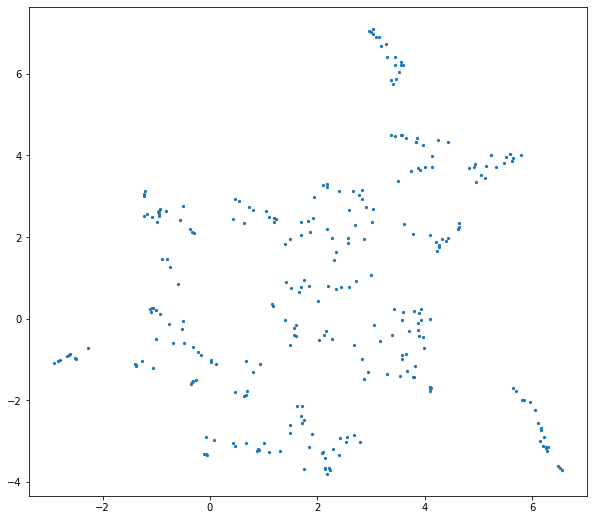

In [765]:
cluster_embedding = reducer.fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1],s=5,cmap='tab10')

In [766]:
df = pd.DataFrame(cluster_embedding)

In [767]:
#coordinate of words

df

,0,1
0,-0.807685,1.462215
1,4.197803,1.868301
2,2.138629,-3.408409
3,1.486671,-2.618109
4,2.795085,-3.027621
...,...,...
280,-2.277071,-0.721042
281,-2.621548,-0.886539
282,1.106151,2.491671
283,-2.652903,-0.914760


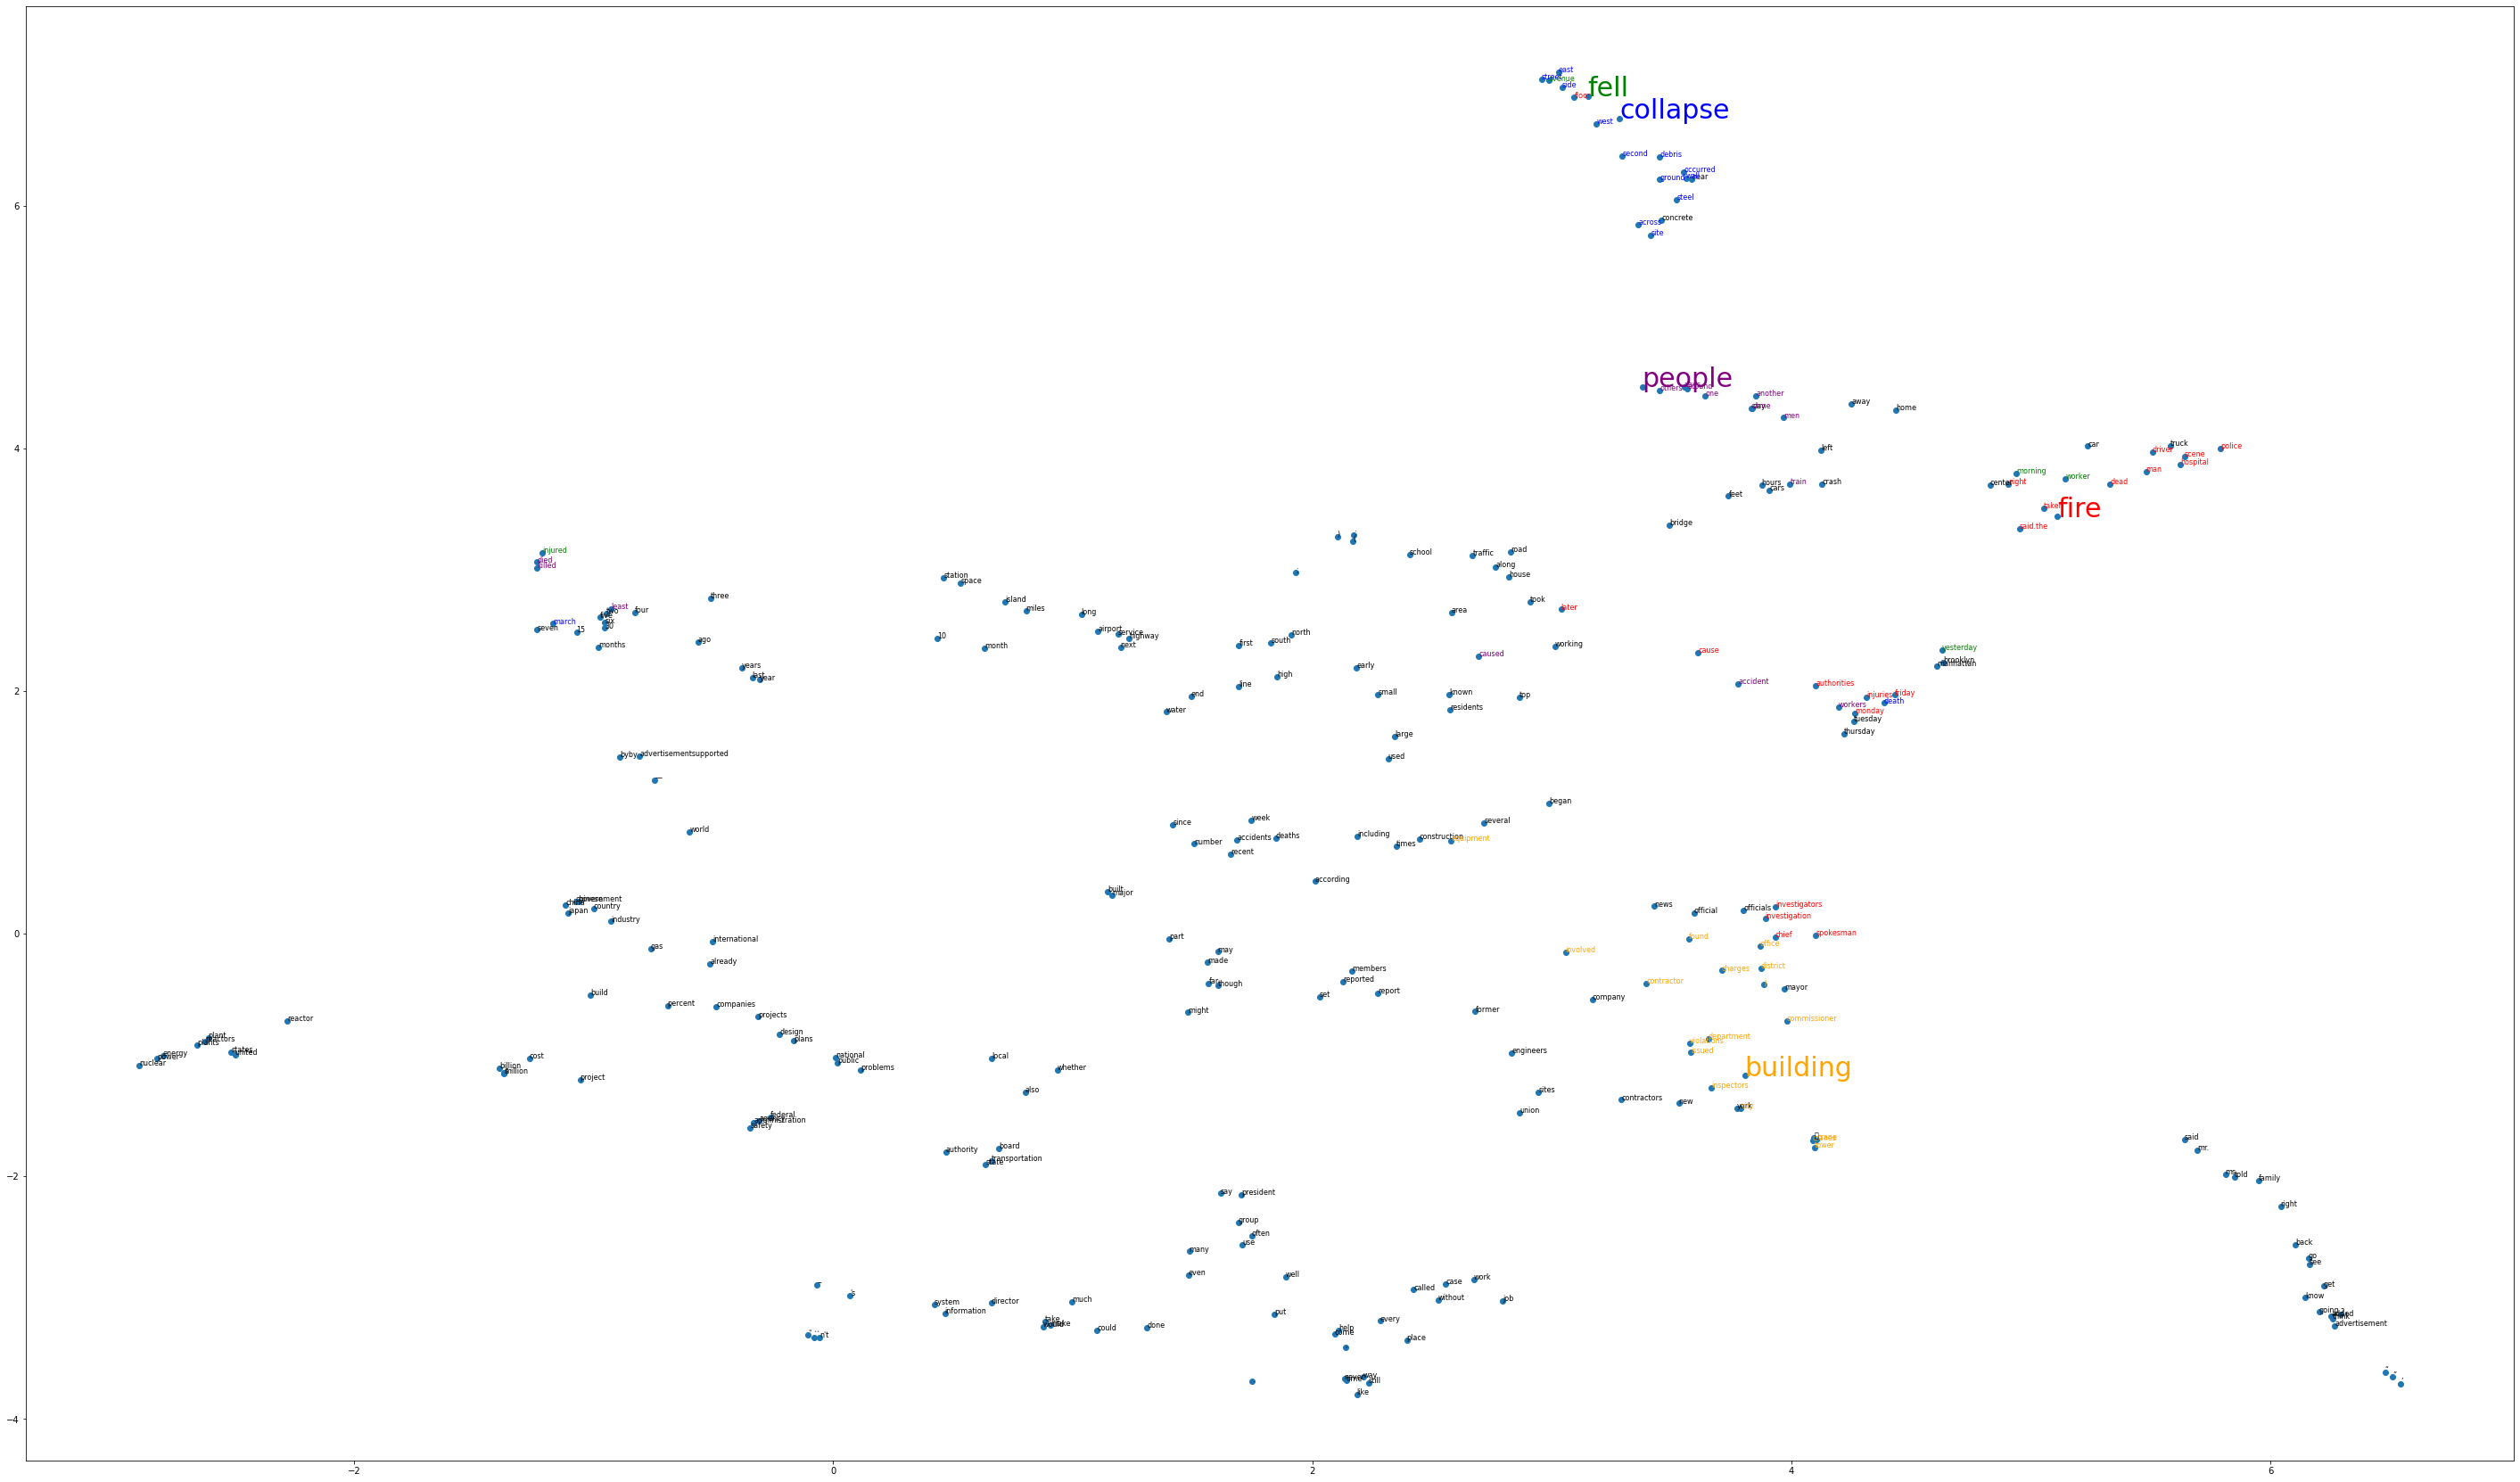

In [823]:
fig = plt.figure()
fig.set_size_inches(50,30)
ax = fig.add_subplot(1,1,1)

ax.scatter(df[0],df[1])

for i, txt in enumerate(X_l):
    
    if txt == 'fire' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'red', fontsize=30)
    elif txt in sim_fire_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='red', fontsize=8)
    elif txt =='fell' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color='green', fontsize=30)
    
    elif txt =='collapse' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'blue', fontsize=30)
    elif txt in sim_collapse_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='blue', fontsize=8)
    
    elif txt =='building' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=30)
    elif txt in sim_building_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=8)

    elif txt in sim_fall_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='green', fontsize=8)        
    
    elif txt =='people' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color = 'purple', fontsize=30)
    elif txt in sim_people_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='purple', fontsize=8)
    else :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
plt.savefig('fire_word2vec_040904_best.png')